# CS 421 PROJECT
---

Group: Empirical Risk Minimisers  
Members:
- Lai Wan Xuan Joanne (joanne.lai.2021)
- Ryan Miguel Moralde Sia (ryansia.2022)
- Dhruv Benegal (benegalda.2022)
- Benedict Lee Zi Le (benedictlee.2022)

### 1. Background & Objective

In this project, you will be working with data extracted from famous recommender systems type datasets: you are provided with a large set of interactions between users (persons) and items (movies). Whenever a user "interacts" with an item, it watches the movie and gives a "rating". There are 5 possible ratings expressed as a "number of stars": 1,2,3,4, or 5. 

In this exercise, we will **not** be performing the recommendation task per se. Instead, you will try to identify the amount of noise/corruption which was injected in each user. Indeed, for each of the users you have been given, an anomaly/noise generation procedure was applied to corrupt the sample. The noise generation procedure depends on two variables: the noise level $p\in [0,1]$ and the noise type $X\in\{0,1,2\}$.  Each user has been randomly assigned a noise level $p$ and anomaly/noise type $X$, and subsequently been corrupted with the associated noise generation procedure. 

You have two tasks: first, you must predict the noise level $p$ associated to each test user. This is a **supervised regression task**. Second, you must try to identify the noise generation type for each user. This is a classification task with three classes, with the possibility of including more classes later depending on class performance. This task will be semi-supervised: only a very small number of labels is provided. You will therefore need to combine supervised and unsupervised approaches for this component. 

### 2. Data

You are provided with three frames: the first one ("X") contains the interactions provided to you, and the second one ("yy") contains the continuous for the users. The third data frame "yy_cat" contains the anomaly/noise type for 15 users. The idea is to use these users to disambiguate the category types, but the task will mostly be unsupervised. 

As you can see, the three columns in "X" correspond to the user ID, the item ID and the rating (encoded into numerical form). Thus, each row of "X" contains a single interaction. For instance, if the row "$142, 152, 5$" is present, this means that the user with ID $142$ has given the movie $152$ a positive rating of $5$.

The dataframe "yy" has two columns. In the first column we have the user IDs, whilst the second column contains the continuous label. A label of $0.01$ indicates a very low anomaly level, whilst a label of $0.99$ indicates a very high amount of noise/corruption. 

### 3. Evaluation

Your task is to be able to regress the noise level $p$ for each new user, and predict the anomaly type $X$. The first (regression) task will be easier due to the larger amount of supervision, and will form the main basis of the evaluation. The second task will be more importance to showcase each team's creativity and differentiate between top performers. 

THE **EVALUATION METRICs** are:  

1. The Mean Absolute Error (MAE) for the regression task. 
2. The accuracy for the classiciation task. 

Every few weeks, we will evaluate the performance of each team (on a *test set with unseen labels* that I will provide) in terms of both metrics

The difficulty implied by **the generation procedure of the anomalies MAY CHANGE as the project evolves: depending on how well the teams are doing, I may generate easier or harder anomaly classes, which would change the number of labels in the classification task**. However, the regression task will still be the same (with a different distribution).

### 4. Deliverables

Together with this file, you are provided with a first batch of examples "`first_batch_regression_labelled.npz`" which are labelled in terms of noise level. You are also provided with the test samples to rank by the next round (without labels) in the file "`second_batch_regression_unlabelled.npz`".

The **first round** will take place after recess (week 9): you must hand in your scores for the second batch before the **Wednesday at NOON (15th of October)**. We will then look at the results together on the Friday.  

We will check everyone's performance in this way every week (once on  week 10, once on week 11 and once on week 12). 

---

To summarise, the project deliverables are as follows:

- Before every checkpoint's deadline, you need to submit **a `.csv` file** containing a dataframe of size $\text{number of test batch users} \times 3$.
    - The first column should be the user IDs of the test batch.
    - The second column should contain the estimated noise level $p$ for each sample.
    - The final column should contain the estimated class (it should be a natural number in \{0,1,2\}).
- The order of rows should correspond to the user IDs. For example, if the test batch contains users 1100-2200, scores for user 1100 should be the first row (row 0), scores for user 1101 should be the second row (row 1), and so on.
- On Week 12-13 (schedule to be decided), you need to present your work in class. The presentation duration is **10 minutes** with 5 minutes of QA.
- On Week 12, you need to submit your **Jupyter Notebook** (with comments in Markdown) and the **slides** for your presentation. 
- On week 13 you need to submit your **final report**. The final report should be 2-3 pages long (consisting of problem statement, literature review, and motivation of algorithm design) with unlimited references/appendix.

Whilst performance (expressed in terms of MAE and accuracy) at **each of the check points** (weeks 9 to 12 inclusive) is an **important component** of your **final grade**, the **final report** and the detail of the various methods you will have tried will **also** be very **important**. Ideally, to get perfect marks (A+), you should try at least **two supervised methods** and **two unsupervised methods**, as well as be ranked the **best team** in terms of performance. 


In addition, I will be especially interested in your **reasoning**. Especially high marks will be awarded to any team that is able to **qualitatively describe** the difference between the two anomaly types. You are also encouraged to compute statistics related to each class and describe what is different about them. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression
    )
from sklearn.metrics import (
    mean_absolute_error,
    accuracy_score
)
from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Data Loading, Cleaning and Exploration

### Data Loading

In [2]:
import numpy as np
import pandas as pd

In [3]:
data  = np.load("data/Week1/first_batch_regression_labelled.npz")
X     = data["X"]
y     = data["yy"]
y_cat = data["yy_cat"]

# Load dataframes
X     = pd.DataFrame(X, columns=["user", "item", "rating"])
y     = pd.DataFrame(y, columns=["user", "label"])
y_cat = pd.DataFrame(y_cat, columns=["user", "label", "anomtype"])

# Parse to correct types
y     = y.astype({"user": int, "label": float})
y_cat = y_cat.astype({"user": int, "label": float, "anomtype": int})

In [4]:
XX    = np.load("data/Week1/second_batch_regression_unlabelled.npz")['X']
XX    = pd.DataFrame(XX, columns=["user", "item", "rating"])

In [5]:
# contains interactions provided
# has 288205 rows

X

,user,item,rating
0,0,94,2
1,0,90,1
2,0,97,2
3,0,100,4
4,0,101,2
...,...,...,...
288200,899,515,3
288201,899,522,1
288202,899,526,4
288203,899,592,2


In [6]:
# contains the noise level p
# has 900 rows corresponding to users

y

print("---To check if number of users in X corresponds to number of rows in y---")
print(f"Number of unique users in X: {X['user'].nunique()}")
print(f"Number of rows in y: {len(y)}")

---To check if number of users in X corresponds to number of rows in y---
Number of unique users in X: 900
Number of rows in y: 900


In [7]:
# contains the anomaly/noise type, which is in {0, 1, 2}
# only has 15 rows

y_cat

,user,label,anomtype
0,561,0.383316,1
1,202,0.925028,2
2,205,0.380860,2
3,424,0.255181,1
4,284,0.055162,2
5,667,0.558745,0
6,730,0.311928,1
7,469,0.233492,2
8,199,0.165112,1
9,699,0.261752,2


In [8]:
# contains test data that we predict anomaly and noise on

XX

,user,item,rating
0,900,0,2
1,900,388,2
2,900,389,3
3,900,390,0
4,900,401,5
...,...,...,...
282441,1799,319,4
282442,1799,318,5
282443,1799,316,3
282444,1799,814,4


### Data Cleaning

In [9]:
# Check for duplicate rows (if a user rated an item more than once)

duplicates = X[X.duplicated(subset=["user", "item"], keep=False)]
print(duplicates.sort_values(by=["user", "item"]))

        user  item  rating
906        3    70       4
969        3    70       5
996        3    70       5
882        3   159       4
1100       3   159       1
...      ...   ...     ...
287744   898   946       2
287724   898   986       3
287809   898   986       3
287664   898   997       2
287791   898   997       3

[43077 rows x 3 columns]


In [10]:
# We found that there are quite a few duplicates (i.e. a user rated an item more than once)
# We assume that a user's final rating is the final decision, and we keep that

X_no_dupes = X.drop_duplicates(subset=["user", "item"], keep="last")

print(X_no_dupes.shape)

(263077, 3)


### Exploratory Data Analysis

,user,mean_rating,label,anomtype,group
0,0,2.435644,NaN,NaN,Unknown anomtype
1,1,2.698507,NaN,NaN,Unknown anomtype
2,2,3.904580,NaN,NaN,Unknown anomtype
3,3,3.801370,NaN,NaN,Unknown anomtype
4,4,4.373737,NaN,NaN,Unknown anomtype
...,...,...,...,...,...
895,895,3.667845,NaN,NaN,Unknown anomtype
896,896,2.965957,NaN,NaN,Unknown anomtype
897,897,3.862179,NaN,NaN,Unknown anomtype
898,898,3.531915,NaN,NaN,Unknown anomtype


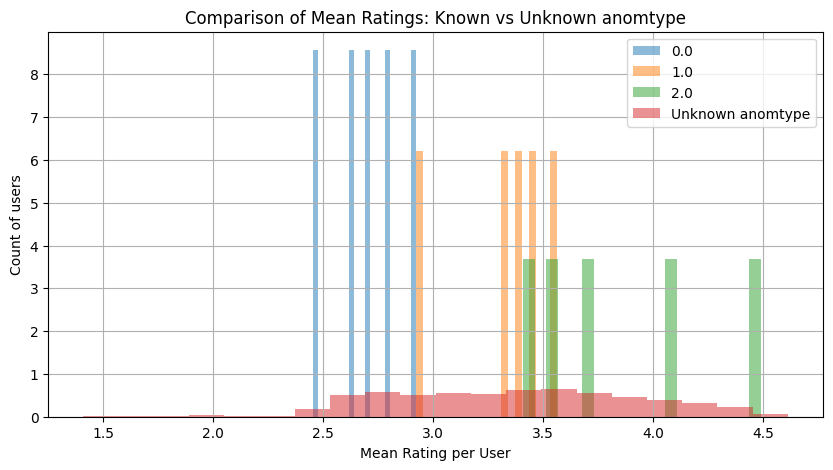

In [11]:
# ben: we should make some graphs here
# Encouraged to compute statistics related to each class and describe what is different about them.

# Step 1: compute mean rating per user from X
user_means = X_no_dupes.groupby("user")["rating"].mean().reset_index(name="mean_rating")

# Step 2: join with anomtype info
user_means = user_means.merge(y_cat, on="user", how="left")

# Step 3: create a "group" column (known vs unknown anomtype)
user_means["group"] = user_means["anomtype"].apply(
    lambda x: x if pd.notnull(x) else "Unknown anomtype"
)

display(user_means)

plt.figure(figsize=(10, 5))
for group, data in user_means.groupby("group"):
    plt.hist(
        data["mean_rating"], 
        bins=20,
        alpha=0.5,
        density=True,
        label=group)

plt.xlabel("Mean Rating per User")
plt.ylabel("Count of users")
plt.title("Comparison of Mean Ratings: Known vs Unknown anomtype")
plt.legend()
plt.grid()
plt.show()

Ben: Seems like classtype 0, 1 and 2 are separated: 
- classtype 0: between 2.4 to 2.9?
- classtype 1: 2.9 to 3.6?
- classtype 2: 3.4 to 4.4?

## Evaluation Functions

In [12]:
# to print MAE for regression task
def evaluate_linear_predictions(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Test MAE: {mae:.4f}")

# to print accuracy for classification task
def evaluate_classification_accuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

## Supervised Learning method 1: Linear Regression

### Feature Engineering

In [13]:
# Create the initial dataframe
# Step 1: Pivot the dataframe, so that the cell in (i,j) is user i's rating of the movie j
final_df = X_no_dupes.pivot(index="user", columns="item", values="rating")

# Step 2: Fill missing values with -1 (to show that it stands for no rating, instead of 0 = hated it)
final_df = final_df.fillna(-1)

# Ensure all items appear as columns (in case there is a movie within range(0, 1000) not inserted)
all_items = range(0, 1000)
final_df = final_df.reindex(columns=all_items, fill_value=-1)

# Merge with labels
final_df = final_df.join(y.set_index("user"))

display(final_df.head())

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,label
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.962817
1,-1.0,-1.0,2.0,3.0,-1.0,2.0,-1.0,-1.0,3.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.031248
2,4.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.068668
3,4.0,2.0,4.0,-1.0,1.0,3.0,-1.0,3.0,5.0,4.0,...,-1.0,-1.0,-1.0,4.0,2.0,-1.0,-1.0,-1.0,-1.0,0.349012
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,...,4.0,-1.0,5.0,5.0,4.0,-1.0,5.0,5.0,-1.0,0.917704


In [14]:
# Prepare and split dataset into train and val
# ben: not sure if need test dataset as of now

# Step 1: Extract features and labels
X = final_df.drop(columns=["label"]).values # Features
y = final_df["label"].values # Labels

# Step 2: Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.2, random_state=42
)

print("Shapes (regression):")
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# X_train, X_temp, y_train, y_temp = train_test_split(
#     X, y, test_size=0.4, random_state=20252026
# )

# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=0.5, random_state=20252026
# )

# print("Shapes (regression):")
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

Shapes (regression):
(720, 1000) (720,) (180, 1000) (180,)


In [15]:
# Standardise features (for regression)

scaler_lr = StandardScaler().fit(X_train)
X_train_std = scaler_lr.transform(X_train)
X_val_std = scaler_lr.transform(X_val)
# X_test_std = scaler_lr.transform(X_test)

### Linear Regression

In [16]:
# We now perform linear regression to predict label

# Train model
lr = LinearRegression()
lr.fit(X_train_std, y_train)

y_pred= lr.predict(X_val_std)
evaluate_linear_predictions(y_val, y_pred)


Test MAE: 0.4021


## Supervised learning method 2: Logistic Regression

### Feature Engineering

We do some more steps in addition to supervised learning, as we have to include column "anomtype" in our training

In [17]:
# Combine dataframe with anomtype

final_df_log = final_df.reset_index().merge(y_cat[["user", "anomtype"]], on="user", how="inner")

# we convert all column names to strings so it does not throw an error later
# ben: or maybe we just shouldnt use the label for logistic regression?
final_df_log.columns = final_df_log.columns.astype(str)
display(final_df_log)
final_df_log["anomtype"].value_counts()

,user,0,1,2,3,4,5,6,7,8,...,992,993,994,995,996,997,998,999,label,anomtype
0,26,2.0,-1.0,-1.0,4.0,3.0,-1.0,4.0,4.0,4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.558222,0
1,199,5.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.165112,1
2,202,5.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,4.0,-1.0,5.0,4.0,-1.0,5.0,5.0,5.0,0.925028,2
3,205,2.0,3.0,2.0,1.0,-1.0,-1.0,-1.0,4.0,4.0,...,-1.0,4.0,-1.0,3.0,-1.0,3.0,-1.0,-1.0,0.380860,2
4,231,3.0,-1.0,4.0,3.0,-1.0,1.0,1.0,-1.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.951103,0
5,284,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,...,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,0.055162,2
6,424,4.0,1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.255181,1
7,459,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.739300,0
8,469,4.0,-1.0,3.0,3.0,-1.0,3.0,-1.0,-1.0,3.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.233492,2
9,561,3.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,0.383316,1


anomtype
0    5
1    5
2    5
Name: count, dtype: int64

In [18]:
# Separate the dataframes into input X and label y
# ben: to determine if we should keep the "label" column. pending discussion

X = final_df_log.drop(columns=["user", "anomtype", "label"])
# X = final_df_log.drop(columns=["user", "anomtype"])
y = final_df_log["anomtype"]

display(X)
display(y)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,2.0,-1.0,-1.0,4.0,3.0,-1.0,4.0,4.0,4.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,5.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,5.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,4.0,4.0,-1.0,5.0,4.0,-1.0,5.0,5.0,5.0
3,2.0,3.0,2.0,1.0,-1.0,-1.0,-1.0,4.0,4.0,-1.0,...,4.0,5.0,-1.0,4.0,-1.0,3.0,-1.0,3.0,-1.0,-1.0
4,3.0,-1.0,4.0,3.0,-1.0,1.0,1.0,-1.0,2.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0
6,4.0,1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,4.0,4.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,4.0,-1.0,3.0,3.0,-1.0,3.0,-1.0,-1.0,3.0,4.0,...,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,3.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,5.0,...,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0


0     0
1     1
2     2
3     2
4     0
5     2
6     1
7     0
8     2
9     1
10    0
11    2
12    1
13    0
14    1
Name: anomtype, dtype: int64

In [19]:
# Scale features in X

scaler_logreg = StandardScaler().fit(X)
X_std=scaler_logreg.transform(X)

Because of the limited sample size, we choose to only train and validate our model as best we can, before predicting on the actual dataset

Ben: can refer to Logistic Regression documentation here  
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [20]:
# Do logistic regression here

log_reg = LogisticRegression(
    penalty="l2", # ridge regression
    C=0.01,
    solver="liblinear", # efficient for small-medium datasets
    max_iter=1000
)

# wrap log_reg in OneVsRest classifier so the liblinear solver works for our multiclass classifier
log_classifier = OneVsRestClassifier(log_reg)

# Using StratifiedKFold, for n_splits=5, we train on 4 folds and validate on the remaining fold
# then compute accuracy based on that fold
cv = StratifiedKFold(n_splits=5)

# Code for GridSearchCV: to find the best value of C
param_grid = {'estimator__C': [0.01, 0.1, 1, 10]}
grid = GridSearchCV(
    estimator=log_classifier,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy'
)

grid.fit(X_std, y)

print("Best C:", grid.best_params_)
print("Best CV Accuracy: %.4f" % grid.best_score_)

cv_results = pd.DataFrame(grid.cv_results_)
display(cv_results[['param_estimator__C', 'mean_test_score', 'std_test_score']])

# Scores will be an array of 5 numbers: one accuracy per fold
# scores = cross_val_score(log_classifier, X_std, y, cv=cv, scoring="accuracy")

# display(scores)
# print("CV Accuracy: %.4f ± %.4f" % (scores.mean(), scores.std()))

Best C: {'estimator__C': 0.1}
Best CV Accuracy: 0.6000


,param_estimator__C,mean_test_score,std_test_score
0,0.01,0.533333,0.339935
1,0.10,0.600000,0.326599
2,1.00,0.600000,0.326599
3,10.00,0.600000,0.326599


In [22]:
# To get final logistic regression model, we choose the best value of C

log_reg = LogisticRegression(
    penalty="l2",
    C=grid.best_params_['estimator__C'],
    solver="liblinear",
    max_iter=1000
)

log_classifier = OneVsRestClassifier(log_reg)

final_model = log_classifier.fit(X_std, y)
final_model

,estimator,LogisticRegre...r='liblinear')
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None


-- This is with GridSearchCV --  
CV accuracy is still low (only 0.6), probably due to too small a number of samples  



-- This was without GridSearchCV--  
[liblinear] CV accuracy with or without "label" column: 0.5333 ± 0.2667  
[lbfgs] CV accuracy with or without "label" column: 0.4000 ± 0.3266  
By observation we can see that liblinear is better with smaller samples, but then again the sample size is too small to make any meaningful conclusion

## Making predictions on second batch

### Data cleaning

In [23]:
# Check for duplicate rows (if a user rated an item more than once)

duplicates = XX[XX.duplicated(subset=["user", "item"], keep=False)]
print(duplicates.sort_values(by=["user", "item"]))

        user  item  rating
488      901    73       4
606      901    73       4
499      901   157       5
570      901   157       4
484      901   172       4
...      ...   ...     ...
282425  1799    26       4
282267  1799   866       4
282372  1799   866       1
282223  1799   930       5
282398  1799   930       5

[41033 rows x 3 columns]


In [24]:
# We found that there are quite a few duplicates (i.e. a user rated an item more than once)
# We assume that a user's final rating is the final decision, and we keep that

XX_no_dupes = XX.drop_duplicates(subset=["user", "item"], keep="last")

print(XX_no_dupes.shape)

(258465, 3)


### Feature Engineering

In [25]:
# Create the initial dataframe
# Step 1: Pivot the dataframe, so that the cell in (i,j) is user i's rating of the movie j
XX_df = XX_no_dupes.pivot(index="user", columns="item", values="rating")

# Step 2: Fill missing values with -1 (to show that it stands for no rating, instead of 0 = hated it)
XX_df = XX_df.fillna(-1)

# Ensure all items appear as columns (in case there is a movie within range(0, 1000) not inserted)
all_items = range(0, 1000)
XX_df = XX_df.reindex(columns=all_items, fill_value=-1)

display(XX_df.head())
print(XX_df.shape)

item,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
user,,,,,,,,,,,,,,,,,,,,,
900,2.0,-1.0,-1.0,3.0,-1.0,2.0,-1.0,-1.0,4.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
901,5.0,4.0,4.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,4.0,4.0,-1.0,4.0,4.0,-1.0
902,4.0,-1.0,3.0,-1.0,-1.0,2.0,-1.0,-1.0,4.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
903,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,3.0,-1.0,-1.0,5.0
904,2.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


(900, 1000)


### Supervised learning prediction

In [26]:
# Generate predictions using the trained linear regression model

XX_df_lr = scaler_lr.transform(XX_df)

yy_label_pred = lr.predict(XX_df_lr)
print(yy_label_pred.shape)

(900,)


### Unsupervised learning prediction

In [27]:
# Generate predictions using the trained logistic regression model

XX_df_logreg = scaler_logreg.transform(XX_df)

yy_label_anomtype = log_classifier.predict(XX_df_logreg)
print(yy_label_anomtype.shape)

(900,)


c:\Users\Ben\anaconda3\envs\cs421\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### Saving the result

In [28]:
# combine dataframe
result_df = XX_df.reset_index()
result_df = result_df[["user"]]
result_df["label"] = yy_label_pred
result_df["anomtype"] = yy_label_anomtype
display(result_df.head(10))

# normalise label column as some predictions are <0 or >1
result_df["label"] = result_df["label"].clip(lower=0, upper=1)

# save as csv
result_df.to_csv('second_batch_output.csv')
print("Result successfully saved")

item,user,label,anomtype
0,900,0.384945,0
1,901,0.810026,0
2,902,0.605242,0
3,903,-0.210483,0
4,904,0.255262,0
5,905,0.602331,0
6,906,0.952141,2
7,907,0.387077,2
8,908,0.368767,2
9,909,-0.556082,2


Result successfully saved
